
# **CIS 5450 Final Project - Car Price Prediction**
*By Alex Jung, Josh Lee, Grace Liu*

# Part 1: Introduction
For our final project, we sought to build a model that predicts the selling price of cars based on various features. We used a dataset from Kaggle to develop the model.

We decided to call this dataset `cp_df` (car price data frame), which includes information about a car's make year, make, model, trim, body, transmission, vehicle identification number, state, condition, odometer, color, interior, seller, Manheim Market Report (estimated price), selilng price, and sale date. Based on these features and new information that we derived, we were able to understand both the quantitative and qualitative factors that affect a car's selling price.


Below in our notebook, we provide a thorough overview of the results. We have added explanations to relevant findings or our motivations behind certain manipulations of the data.

We hope this notebook can be an aid to your next car search.

# Part 2: Data Loading and Preprocessing

## 2.1 Imports and Data Loading
Before jumping into data manipulation, we sought to install dependencies and import libraries that will be necessary for future analysis.

In [ ]:
!pip install optuna
!pip install pandasql

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import pandasql as ps
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import optuna
from scipy import stats
from scipy.stats import spearmanr, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

We mount the local google drive to the current runtime and create a kaggle directory, which will pull our dataset from the Kaggle website.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the kaggle directory
!mkdir -p ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!kaggle datasets download -d syedanwarafridi/vehicle-sales-data

Dataset URL: https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data
License(s): MIT
vehicle-sales-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip folder in Colab content folder
!unzip /content/vehicle-sales-data.zip

Archive:  /content/vehicle-sales-data.zip
replace car_prices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 2.2 Data Cleaning and Basic Analysis

We first seek to look into the dataset by observing its columns and the types of values they contain.

In [ ]:
# Read the csv file and save it to a dataframe called "cp_df"
cp_df = pd.read_csv("car_prices.csv")
# Check out the first five rows
cp_df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


To get an overview of the numerical and categorical variables and make sure that the column data types align with our expectations, we call the `info()` function on `cp_df`.


In [ ]:
#Check out the column types and shape of the dataframe
cp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


For the numerical variables, we call the `describe()` function in hopes of getting insights from the summary statistics

In [ ]:
#Determine summary statistics for each of the numerical variables
cp_df.describe()

,year,condition,odometer,mmr,sellingprice
count,558837.000000,547017.000000,558743.000000,558799.000000,558825.000000
mean,2010.038927,30.672365,68320.017767,13769.377495,13611.358810
std,3.966864,13.402832,53398.542821,9679.967174,9749.501628
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28371.000000,7100.000000,6900.000000
50%,2012.000000,35.000000,52254.000000,12250.000000,12100.000000
75%,2013.000000,42.000000,99109.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


We observe null values for each column by calling `isna().sum()` -- `make`, `model`, `trim`, `body`, `transmission`, and `condition` seem to have a good amount of nulls.

In [ ]:
#Check number of missing values for each column
cp_df.isna().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

We observe the cardinality of each column by calling `nunique()` to get an idea of how many variations we have especially for the categorical variables.

In [ ]:
#Check number of unique values for each column
cp_df.nunique()

year                34
make                96
model              973
trim              1963
body                87
transmission         4
vin             550297
state               64
condition           41
odometer        172278
color               46
interior            17
seller           14263
mmr               1101
sellingprice      1887
saledate          3766
dtype: int64

We noticed that the Vehicle Identification Number (`vin`) has the most variations. This was corroborated by a quick Google search. Thus, it is not useful for our analysis and we drop the column.

We also drop the `seller` column because the high cardinality may lead to overfitting. We reason that although the pricing strategies of different sellers may vary, these patterns are probably insignificant in comparison to other variables.

We decided to implement this dropping process with PandaSQL.



In [ ]:
# Run SQL query to drop columns 'vin', 'mmr', and 'seller'
cp_df = ps.sqldf('''
SELECT
    year,
    make,
    model,
    trim,
    body,
    transmission,
    state,
    condition,
    odometer,
    color,
    interior,
    sellingprice,
    saledate
FROM cp_df
''')

We then try dropping nulls to see how much data we lose.

In [ ]:
#Dropping null values
cp_df.dropna(inplace=True)

In [ ]:
#Check out the column types and shape of the dataframe after dropping nulls
cp_df.info()

We notice that dropping rows with null values results in minimal data loss. Most nulls are in categorical columns, where the best strategy would be to impute values with the mode of that column. We reason that this might degrade model performance by distorting the natural distribution of data. Thus, we proceed with the analysis on the modified dataframe with no nulls.

Now, we try to familiarize ourselves with the categorical features.

By making all values in the `body` column lowercase, we avoid the same values being recognized as different just because of casing.

In [ ]:
#Generate a list of body categories
cp_df['body'] = cp_df['body'].str.lower()
cp_df['body'].unique()

We notice that the body categories vary in specificity. For example, the granturismo convertible category is a subcategory of convertible. To address this, we group the specific categories with their corresponding general categories.

In [ ]:
#List of the general categories
body_types = ['suv', 'sedan', 'convertible', 'coupe', 'wagon', 'hatchback', 'cab', 'van', 'minivan']
cp_df['body_type'] = 'other'
#Replace with general category if general category is a substring of the body value, r
for bt in body_types:
  cp_df['body_type'] = np.where(cp_df['body'].str.contains(bt, case=False), bt, cp_df['body_type'])

The range of unique values has decreased significantly with this manipulation.

In [ ]:
cp_df['body_type'].value_counts()

Having "other" as a body type does not provide us much insight. Thus, we seek to look into these values and extract useful information.

We found that the only two variations of `body_type` under "other" were "supercrew" and "koup". Via a quick Google search, we found that "supercrew" falls under the "cab" category and "koup" falls under "coupe".

In [ ]:
cp_df[cp_df['body_type'] == 'other']['body'].unique()

In [ ]:
#Handle the cases where specific category does not contain substring of general category
cp_df.loc[cp_df['body'] == 'supercrew', 'body_type'] = 'cab'
cp_df.loc[cp_df['body'] == 'koup', 'body_type'] = 'coupe'

In [ ]:
cp_df['body_type'].value_counts()

In [ ]:
cp_df.info()

The cardinality of the `model` column is large. We will have to deal with this in future steps.

In [ ]:
cp_df['model'].unique()

We seek to gain insight on the average selling price by body type. We chose plotly as our visualization tool because the hover function allows us to get the exact value for each bar as well as its standard deviation.

The variations for every body type is decently significant but the average selling price for all body types are close to each other within the \$10k - \$20k range.

A video recording of the interactive scatter plot in action can be found [here](https://drive.google.com/file/d/1iLqJ08C0oJR2qp-F8ugw-93g3s-Cwx2E/view?usp=sharing)

In [ ]:
import plotly.graph_objects as go

# Group the data by 'body_type' and calculate mean and standard deviation
grouped_data = cp_df.groupby('body_type')['sellingprice']
average_prices = grouped_data.mean().sort_values(ascending=False)
std_deviation = grouped_data.std()
std_deviation = std_deviation.loc[average_prices.index]

# Create the bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=average_prices.index,
    y=average_prices,
    error_y=dict(type='data', array=std_deviation, visible=True),
    marker_color='skyblue'
))

# Update layout
fig.update_layout(
    title='Average Selling Price by Car Body Type',
    xaxis_title='Car Body Type',
    yaxis_title='Average Selling Price ($)',
    xaxis=dict(tickangle=-90),
    bargap=0.4
)

# Show the plot
fig.show()

A video recording of the interactive scatter plot in action can be found [here](https://drive.google.com/file/d/1jIO-BWFQ-O_Qss8dM-m7kzMSCgGagC_-/view?usp=sharing)

In [ ]:
# Create scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=cp_df['odometer'],
    y=cp_df['sellingprice'],
    mode='markers',
    marker=dict(color='blue'),
))

# Update layout
fig.update_layout(
    title='Selling Price vs. Odometer',
    xaxis_title='Odometer (mi.)',
    yaxis_title='Selling Price ($)',
    showlegend=False,
    height=600,
    width=1000,
)

# Show the plot
fig.show()

As one can expect, `odometer`, which indicates the mileage usage of the car so far, would have a close relationship with the its selling price.

A general trend where a lower `odometer` value corresponds with a high selling price and vice versa can be observed. However, it is also interesting to see that there were many cases where cars with low `odometer` values were also sold at low prices. We assume this may relate to the particular type of car that was sold.

##2.3 More Data Visualizations

To better understand the distributions of the numerical variables beyond the summary statistics and prepare to remove outliers, we create box plots for each of the numerical variables.

As seen similarly from the Selling Price vs. Odometer plot, we can observe concentration of odometer readings within the 0M - 0.4M range.

In [ ]:
#Create box plot for odometer
plt.figure(figsize=(10, 6))
plt.boxplot(cp_df['odometer'])
plt.title('Distribution of Odometer Readings Before Dropping Outliers')
plt.ylabel('Odometer Readings')
plt.grid(True)
plt.show()

We see that there are multiple vehicles with odometer readings exceeding 600000 miles. These readings are probably misentered because this is impractical.

Condition ratings are also mainly concentrated within the 25 - 40 range.

In [ ]:
#Create box plot for condition
plt.figure(figsize=(10, 6))  # Sets the figure size
plt.boxplot(cp_df['condition'])  # Drops NA values to avoid errors in plotting
plt.title('Distribution of Condition Ratings')  # Adds a title to the plot
plt.ylabel('Condition Ratings')  # Adds a label to the y-axis
plt.grid(True)  # Adds a grid for easier readability
plt.show()

We then create a scatter matrix to observe relationships between numerical columns. Interesting results can be found here as several plots rather resemble a bar graph as opposed to a typical scatter plot.

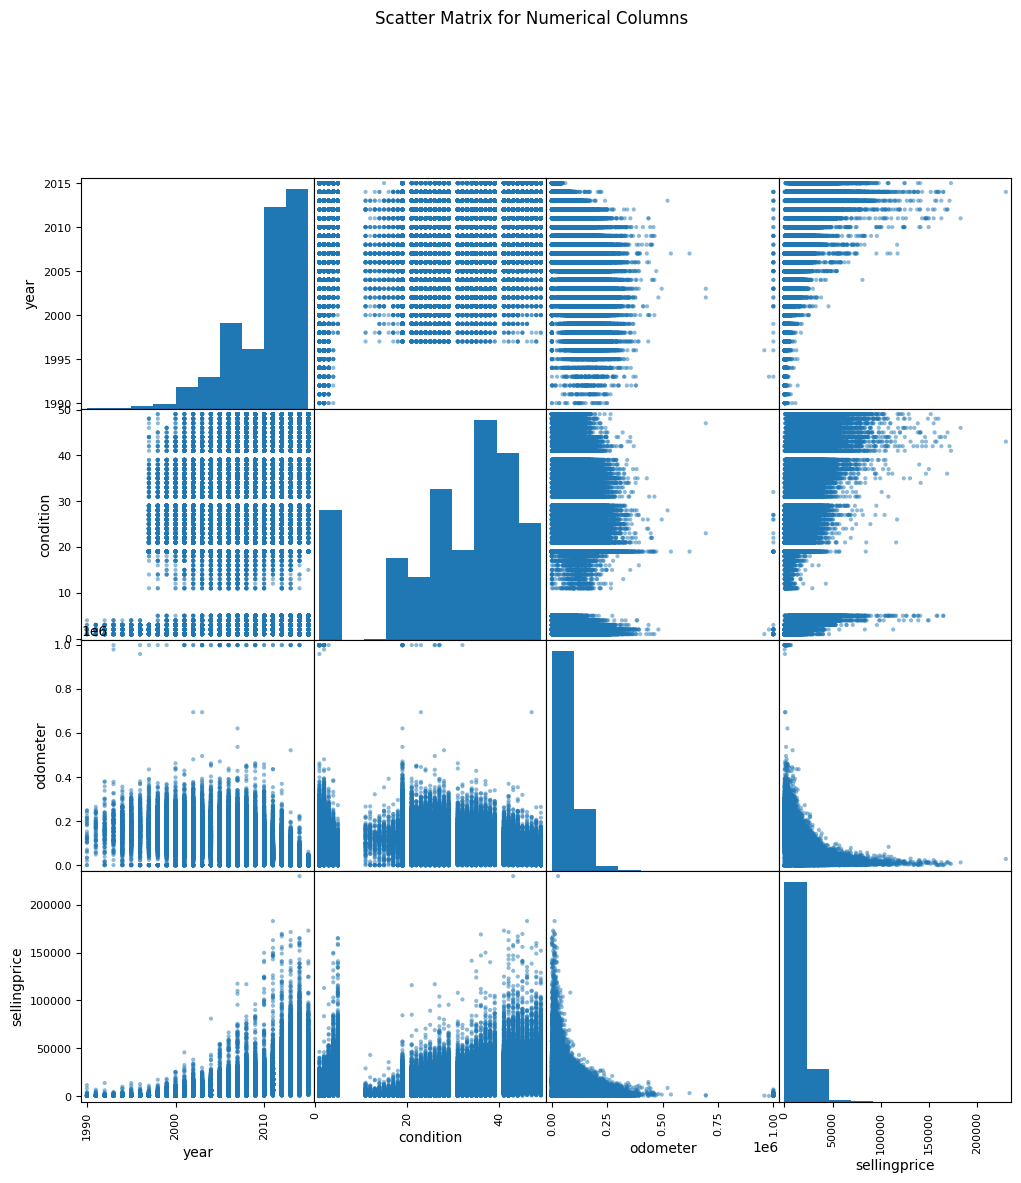

In [ ]:
#Create scatter matrix to visualize relationships between numerical columns
numerical_columns = cp_df.select_dtypes(include=['float64', 'int64']).columns
scatter_matrix(cp_df[numerical_columns], alpha=0.5, figsize=(12, 12), diagonal='hist')
plt.suptitle('Scatter Matrix for Numerical Columns', y=1.02)
plt.show()

#Part 3: Feature Engineering

We reason that the sale date of a car is only meaningful in comparison to the year of the model. We create a new feature representing the age of the car at the time of the sale by extracting the sale year from the sale date with regex and subtracting the model year. We then drop the sale date column.

In [ ]:
#Extracting the sale year from sale date with regex
regex_pattern = '(\d{4})'
#cp_df['age'] = 2024 - cp_df['year']
cp_df['saleyear'] = cp_df['saledate'].str.extract(regex_pattern)
cp_df['saleyear'] = cp_df['saleyear'].astype(int) #cast to int
cp_df['age'] = cp_df['saleyear'] - cp_df['year']+1 #create column for age of car at sale. Add one to prevent age from being a negative value
cp_df.drop(columns=['saledate', 'saleyear'], inplace=True)

Although it may initially seem incorrect that some cars have negative age, it turns out that each year's iteration of a given car is released midway through the following year.

Our box plots of numerical variables from earlier demonstrated the need to drop outliers.

In [ ]:
#Dropping outliers based on z-score
numerical_cols = ['condition', 'odometer', 'age', 'sellingprice']
z_scores = stats.zscore(cp_df[numerical_cols])
cp_df = cp_df[(z_scores < 2).all(axis=1)]

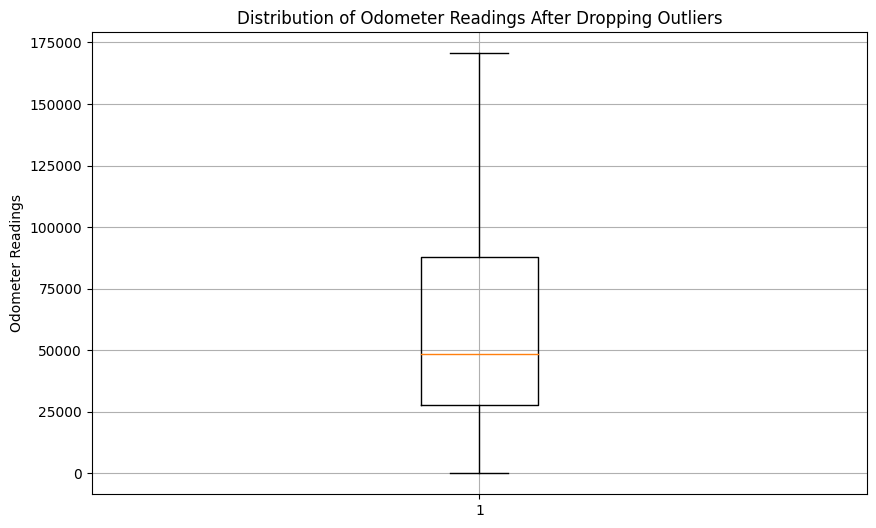

In [ ]:
#Creating another box plot for odometer
plt.figure(figsize=(10, 6))
plt.boxplot(cp_df['odometer'])
plt.title('Distribution of Odometer Readings After Dropping Outliers')
plt.ylabel('Odometer Readings')
plt.grid(True)
plt.show()

We seek to create a correlation heatmap which will give us insight on which numerical variables may be highly correlated to each other.

The variable pairs (`odometer`, `age`), (`odometer`, `sellingprice`), and (`age`, `sellingprice`) seem to have a fairly high correlation. Logically, this makes sense as a longer a car is used, it should have higher mileage, which would lead to a lower selling price.

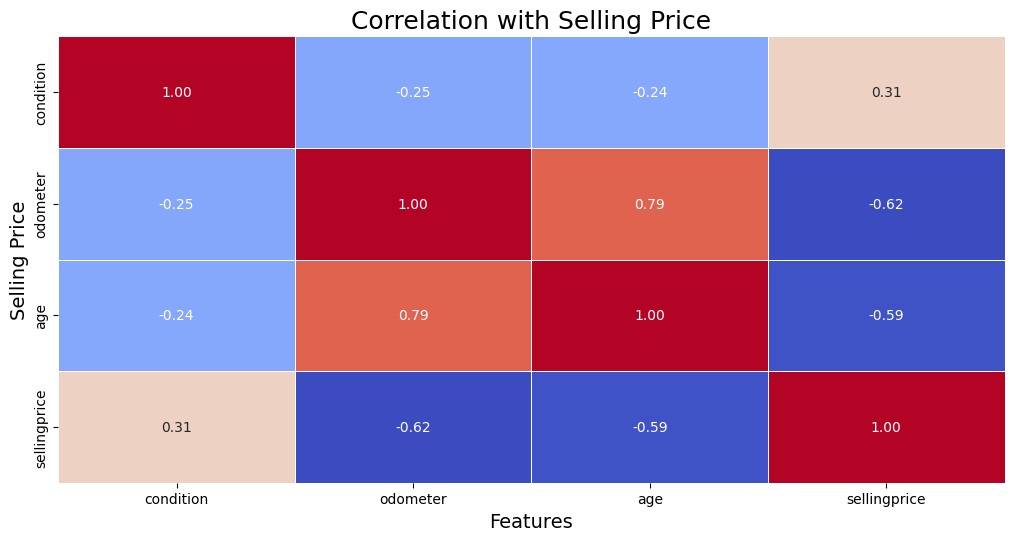

In [ ]:
#Create correlation heatmap
plt.figure(figsize=(10, 5))
numeric_cols = ['condition','odometer','age','sellingprice']

sns.heatmap(cp_df[numeric_cols].corr(),
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar = False,
            )

plt.tight_layout()
plt.title('Correlation with Selling Price', fontsize=18)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Selling Price', fontsize=14)
plt.show()

Because the previous heatmap only computes the correlation between numerical features, we implement the [Spearman rank-order correlation metric](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to determine the correlation between the categorical variables and `sellingprice`.

The categorical variables are not highly correlated with `sellingprice`.

In [ ]:
# Correlation between make and sellingprice
corr, pval = spearmanr(cp_df['sellingprice'], cp_df['make'])
print('Correlation between Make & SellingPrice: ' + str(corr))

# Correlation between body and sellingprice
corr, pval = spearmanr(cp_df['sellingprice'], cp_df['body_type'])
print('Correlation between Body Type & SellingPrice: ' + str(corr))

# Correlation between transmission and sellingprice
corr, pval = spearmanr(cp_df['sellingprice'], cp_df['transmission'])
print('Correlation between Transmission & SellingPrice: ' + str(corr))

# Correlation between state and sellingprice
corr, pval = spearmanr(cp_df['sellingprice'], cp_df['state'])
print('Correlation between State & SellingPrice: ' + str(corr))

# Correlation between color and sellingprice
corr, pval = spearmanr(cp_df['sellingprice'], cp_df['color'])
print('Correlation between Color & SellingPrice: ' + str(corr))

# Correlation between interior and sellingprice
corr, pval = spearmanr(cp_df['sellingprice'], cp_df['interior'])
print('Correlation between Interior & SellingPrice: ' + str(corr))

Correlation between Make & SellingPrice: -0.0031241920577297333
Correlation between Body Type & SellingPrice: 0.031204011379366316
Correlation between Transmission & SellingPrice: -0.0570417775405339
Correlation between State & SellingPrice: -0.02113158476680911
Correlation between Color & SellingPrice: 0.03916887067873846
Correlation between Interior & SellingPrice: -0.13100183918277497


We drop `trim`, `model`, `age`, and `body` to avoid multicollinearity issues. As the correlation matrix shows, `age` is highly correlated with `odometer`. Out of the two, we choose to keep odometer because it is a continuous variable.

In [ ]:
#Drop the aforementioned columns
cp_df.drop(columns=['trim', 'model', 'age', 'body'], inplace=True)
cp_df.head()

<ipython-input-61-0134290e01c9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,make,transmission,state,condition,odometer,color,interior,sellingprice,body_type
0,2015,Kia,automatic,ca,5.0,16639.0,white,black,21500.0,suv
1,2015,Kia,automatic,ca,5.0,9393.0,white,beige,21500.0,suv
2,2014,BMW,automatic,ca,45.0,1331.0,gray,black,30000.0,sedan
3,2015,Volvo,automatic,ca,41.0,14282.0,white,black,27750.0,sedan
5,2015,Nissan,automatic,ca,1.0,5554.0,gray,black,10900.0,sedan


In [ ]:
cp_df.head()

,year,make,transmission,state,condition,odometer,color,interior,sellingprice,body_type
0,2015,Kia,automatic,ca,5.0,16639.0,white,black,21500.0,suv
1,2015,Kia,automatic,ca,5.0,9393.0,white,beige,21500.0,suv
2,2014,BMW,automatic,ca,45.0,1331.0,gray,black,30000.0,sedan
3,2015,Volvo,automatic,ca,41.0,14282.0,white,black,27750.0,sedan
5,2015,Nissan,automatic,ca,1.0,5554.0,gray,black,10900.0,sedan


#Part 4: Preparing for Modeling

To prepare for modeling, we had to process the raw data further to be more fit. Many of our variables are categorical: `make`, `transmission`, `state`, `color`, `interior`, `body_type`. Thus, to run our regression models on these variables, we had to utilize different encoding methods that convert the categorical inputs into numerical ones. We experimented with various methods including one hot encoding and label encoding. We utilized both encoding methods on our models and found that depending on the model, there was a better encoding method based on performance and computing cost, which we will dive further into in part 5.

With the one hot encoded data frame, the number of features expand significantly, which may impact performance and computing costs when running our model. We also realized there may still be multicollinearity issues in our data. For example, the condition of the car probably is correlated with other variables such as odometer. This multicollinearity issue which may impact effectiveness of our models combined with the number of features led us to utilize the unsupervised ML technique in PCA. Because PCA is not scale invariant, we had to normalize our data first before inputting it for PCA.

##4.1 Encoding Categorical Variables

We have several categorical variables in our data set: `make`, `transmission`, `state`, `color`, `interior`, `body_type`. We need these inputs to be numerical, and thus utilize label encoding and one hot encoding as shown below.

### 4.1.1 Label Encoding

In [ ]:
#Label encoding categorical variables
categorical_cols = ['make', 'transmission', 'state', 'color', 'interior', 'body_type']
label_encoded_cp_df = cp_df.copy()
for col in categorical_cols:
  encoder = LabelEncoder()
  label_encoded_cp_df[col] = encoder.fit_transform(cp_df[col])
label_encoded_cp_df.columns

Index(['year', 'make', 'transmission', 'state', 'condition', 'odometer',
       'color', 'interior', 'sellingprice', 'body_type'],
      dtype='object')

### 4.1.2 One Hot Encoding


In [ ]:
# One-hot encode categorical variables
encoded_cp_df = cp_df.copy()
one_hot_cp_df = pd.get_dummies(encoded_cp_df, columns = ['make', 'transmission','state','color','interior','body_type'])

In [ ]:
# Check new encoded dataframe
# Select columns to exclude
columns_to_exclude = ['year', 'condition', 'odometer', 'sellingprice', 'age']

# Convert True to 1 and False to 0 for selected columns
one_hot_cp_df.loc[:, ~one_hot_cp_df.columns.isin(columns_to_exclude)] = one_hot_cp_df.loc[:, ~one_hot_cp_df.columns.isin(columns_to_exclude)].astype(int)
one_hot_cp_df.head(5)

,year,condition,odometer,sellingprice,make_Acura,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,...,interior_—,body_type_cab,body_type_convertible,body_type_coupe,body_type_hatchback,body_type_minivan,body_type_sedan,body_type_suv,body_type_van,body_type_wagon
0,2015,5.0,16639.0,21500.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015,5.0,9393.0,21500.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2014,45.0,1331.0,30000.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2015,41.0,14282.0,27750.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,2015,1.0,5554.0,10900.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 4.2 Train/Test Split

We need to partition both the data that used one hot encoding and label encoding into training data and test data. Based on our past homework and convention we utilize a 80/20 train/test split.
Because PCA is not scale invariant, we apply the `StandardScaler()` object to normalize both the training and test data. If the data is not standardized, our PCA outcome will be different.

### 4.2.1 Train/Test Split for One Hot Encoded Data

In [ ]:
#Extract non-target variables
X_hot = one_hot_cp_df.drop(['sellingprice'], axis = 1)

#Extract target variable
y_hot = one_hot_cp_df['sellingprice']

# Split the data into training and testing sets with stratification and shuffling
seed = 12345
X_train, X_test, y_train, y_test = train_test_split(X_hot, y_hot, test_size=0.2, random_state=seed)

In [ ]:
#Scale the data because PCA is not scale-invariant
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### 4.2.2 Train/Test Split for Label Encoded Data

In [ ]:
seed = 12345
#Non-target variables
X = label_encoded_cp_df.drop(['sellingprice'], axis = 1)
#Target variable
y = label_encoded_cp_df['sellingprice']

# Split the data into training and testing sets with stratification and shuffling
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X, y, test_size=0.2, random_state=seed)

## 4.3 Principal Component Analysis

We run PCA on the data that uses one hot encoding. There are currently 129 features and we plot cumulative explained variance and number of features to figure out our optimal number of features.


In [ ]:
#Instantiate and fit PCA
pca = PCA()
pca.fit(X_train_sc)
# Get explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_
# Calculate cumulative explained variance ratios
cum_evr = np.cumsum(explained_variance_ratios)

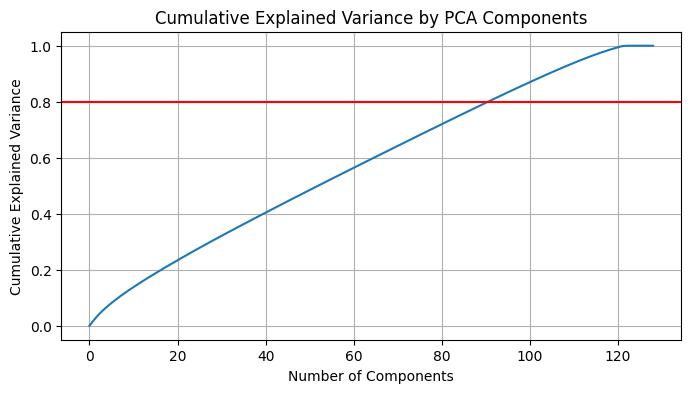

In [ ]:
# # Plotting the explained variance vs number of components
cum_evr = np.insert(cum_evr, 0, 0)
plt.figure(figsize=(8, 4))
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.grid(True)
plt.show()

We want to select the minimum number of components that will explain 80% of the variance. From the plot, it's obvious that we should use 90 components. We update the training and test data to reflect this.

In [ ]:
#Refitting the data using the new PCA object with 90 components
pca_optimal_components = PCA(n_components = 90)

X_train_pca = pca_optimal_components.fit_transform(X_train_sc)
X_test_pca = pca_optimal_components.transform(X_test_sc)

# Part 5: Modeling
We have prepared our data for modeling and split into test and training sets. In this section, we will implement three models on the label encoded and one hot encoded data and evaluate their performances.

## 5.1 Baseline Linear Regression Model



We begin with a linear regression model as our baseline model. Linear regressions are straightforward to implement and require minimal computation, giving us a good starting point that we can compare with the more complex models we develop later.

### 5.1.1 One Hot Encoded PCA Transformed Data

Linear regression models without regularization do not take in hyperparameters, so we do not need to perform any sort of hyperparameter optimization before implementing the model. Although this model is scale-invariant, we use the PCA transformed data frame anyways. Reducing the number of features should help avoid overfitting by reducing noise in the data. It will also be more computationally efficient.

In [ ]:
#Fit a linear regression model on the PCA transformed data
lin_model_pca = LinearRegression()
lin_model_pca.fit(X_train_pca, y_train)
#Predict on transformed data using linear regression model
train_pred_lin = lin_model_pca.predict(X_train_pca)
test_pred_lin = lin_model_pca.predict(X_test_pca)

### 5.1.2 Evaluating the One Hot Encoded Linear Regression

Because the PCA transforms the original features into a set of new components, it does not make sense to analyze regression coefficients on this model. Finding out which of the components is most important will not give us insights as to which of the original features was most important.

In [ ]:
#Calculation of mean squared error (MSE )and mean absolute error (MAE) for test and training sets
mae_test_lin = mean_absolute_error(y_test, test_pred_lin)
mse_test_lin = mean_squared_error(y_test, test_pred_lin)
mae_train_lin = mean_absolute_error(y_train, train_pred_lin)
mse_train_lin = mean_squared_error(y_train, train_pred_lin)

print("MAE Test: " + str(mae_test_lin))
print("MSE Test: " + str(mse_test_lin))
print("MAE Train: " + str(mae_train_lin))
print("MSE Train: " + str(mse_train_lin))

MAE Test: 3570.3526513801135
MSE Test: 21247407.358480852
MAE Train: 3560.893221261742
MSE Train: 21065297.83143341


In [ ]:
#Calculation of R^2 for test and training sets
r2_test_lin = r2_score(y_test, test_pred_lin)
r2_train_lin = r2_score(y_train, train_pred_lin)

print("R-squared Test: " + str(r2_test_lin))
print("R-squared Train: " + str(r2_train_lin))

R-squared Test: 0.5811387412035911
R-squared Train: 0.5816532314998117


The $R^{2}$, MSE, and MAE are consistent across the test and training sets. Although the $R^{2}$ of ~0.66 is a good start, this in addition to the large MSE suggests that the current model is underfitting. This might be because the matrix generated by one hot encoding a column with high cardinality is sparse, leading to the dilution of signals. We should try to increase the model complexity or implement a different encoding method.

### 5.1.3 Label Encoded Data

Now, we try fitting a linear regression model on the label encoded data.

In [ ]:
#Fit a linear regression model on the label encoded data
lin_model = LinearRegression()
lin_model.fit(X_train_le, y_train_le)
#Predict on label encoded data using linear regression model
train_pred_lin = lin_model.predict(X_train_le)
test_pred_lin = lin_model.predict(X_test_le)

### 5.1.4 Label Encoded Linear Regression Feature Importances

In [ ]:
#Extract coefficients from the model
lin_coefficients = lin_model.coef_
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lin_coefficients})

# Optionally, add the intercept
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [lin_model.intercept_]})
coef_df = pd.concat([intercept_row, coef_df], ignore_index=True)
coef_df.sort_values(by=['Coefficient'], ascending=True)
# Display the DataFrame
print(coef_df)

        Feature   Coefficient
0     Intercept -1.227425e+06
1          year  6.193764e+02
2          make -4.360835e+01
3  transmission -1.273280e+03
4         state -7.149719e+00
5     condition  8.412735e+01
6      odometer -6.520454e-02
7         color -2.297210e+01
8      interior -2.194298e+01
9     body_type -4.722575e+02


**Feature Importance for Linear Regression**

### 5.2.1 Evaluating the Label Encoded Linear Regression

In [ ]:
#Calculation of mean squared error (MSE) and mean absolute error (MAE) for test and training set
mae_test_lin = mean_absolute_error(y_test_le, test_pred_lin)
mse_test_lin = mean_squared_error(y_test_le, test_pred_lin)
mae_train_lin = mean_absolute_error(y_train_le, train_pred_lin)
mse_train_lin = mean_squared_error(y_train_le, train_pred_lin)

print("MAE Test: " + str(mae_test_lin))
print("MSE Test: " + str(mse_test_lin))
print("MAE Train: " + str(mae_train_lin))
print("MSE Train: " + str(mse_train_lin))

MAE Test: 4165.501573267299
MSE Test: 27983177.532175697
MAE Train: 4148.4882455858215
MSE Train: 27708053.36218573


In [ ]:
#Calculation of R^2 for test and training sets
r2_test_lin = r2_score(y_test_le, test_pred_lin)
r2_train_lin = r2_score(y_train_le, train_pred_lin)

print("R-squared Test: " + str(r2_test_lin))
print("R-squared Train: " + str(r2_train_lin))

R-squared Test: 0.4483529793308142
R-squared Train: 0.44973127471265306


Again, the $R^{2}$, MSE, and MAE are consistent across the test and training sets. The $R^{2}$ of ~0.45 is worse than that for the one-hot encoded data, suggesting that the effects of artificial ordinality are more harmful than the effects of signal dilution for a linear regression model. This is also influenced by the magnitude of cardinalities in categorical columns in this dataset.

## 5.2 Random Forest Model

The next model we try is a random forest model, which is more complex than a linear regression. Because Random Forest models do not assume any form of relationship between the predictors and the target variable, they should be robust to the artificial ordinality imposed by the label encoding. We expect the model performance to improve for both of these reasons.

### 5.2.1 Hyperparameter Tuning with GridSearchCV

We conduct hyperparameter tuning using GridSearchCV. With our selection of each of the grid parameters to test, we must carefully consider the balance between computational cost, sufficient complexity, and potential for overfitting. Our grid contains the conventional values for each parameter.

In [ ]:
#Extract the optimal combination of parameters from the grid search
rf_optimal_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'min_samples_leaf': 5,
    'min_samples_split': 12
}

'''
This is the code that was run to obtain those optimal parameters
#Initial hyperparameter grid based on conventional values
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 30, 40],
    'min_samples_split': [8, 12],
    'min_samples_leaf': [4, 5]
}

#Create random forest model
rf_model = RandomForestRegressor(random_state=42)
#Initialize grid search
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
rf_grid_search.fit(X_train_le, y_train_le)
'''

"\nThis is the code that was run to obtain those optimal parameters\n#Initial hyperparameter grid based on conventional values\nrf_param_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [10, 30, 40],\n    'min_samples_split': [8, 12],\n    'min_samples_leaf': [4, 5]\n}\n\n#Create random forest model\nrf_model = RandomForestRegressor(random_state=42)\n#Initialize grid search\nrf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)\nrf_grid_search.fit(X_train_le, y_train_le)\n"

In [ ]:
#Fit a Random Forest model on the training data using the optimal parameters from the previous step
optimal_rf_model = RandomForestRegressor(**rf_optimal_params)
optimal_rf_model.fit(X_train_le, y_train_le)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=12,
                      n_estimators=50)

### 5.2.2 Random Forest Feature Importance

Now that we optimized our model, we want to better understand feature importances. This step is important to establish how the results of our model should be understood in practical applications.

In [ ]:
#Extract feature importances from the model
rf_feature_importances = optimal_rf_model.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
#Plotting a bar graph to visually represent feature importances
fig = go.Figure(go.Bar(
    x=rf_importance_df['Feature'],
    y=rf_importance_df['Importance'],
    marker_color='skyblue'
))

# Update layout with title and axes titles
fig.update_layout(
    title='Feature Importances',
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis=dict(tickangle=-90),
    width=1000,
    height=600,
)

# Show the plot
fig.show()

### 5.2.3 Evaluating Random Forest Models

We calculate the same metrics as we did for the linear regression to compare the model performances.

In [ ]:
#Use the random forest model to make predictions on the test and training data
test_pred_rf = optimal_rf_model.predict(X_test_le)
train_pred_rf = optimal_rf_model.predict(X_train_le)

#Calculate the MSE and MAE for the random forest predictions
mae_test_rf = mean_absolute_error(y_test_le, test_pred_rf)
mse_test_rf = mean_squared_error(y_test_le, test_pred_rf)
mae_train_rf = mean_absolute_error(y_train_le, train_pred_rf)
mse_train_rf = mean_squared_error(y_train_le, train_pred_rf)

print("MAE Test: " + str(mae_test_rf))
print("MSE Test: " + str(mse_test_rf))
print("MAE Train: " + str(mae_train_rf))
print("MSE Train: " + str(mse_train_rf))

MAE Test: 2691.9290359640972
MSE Test: 13448270.9013494
MAE Train: 2647.8455304582026
MSE Train: 12977550.592769738


In [ ]:
#Calculate the R^2 for the random forest model
r2_test_rf = r2_score(y_test_le, test_pred_rf)
r2_train_rf = r2_score(y_train_le, train_pred_rf)

print("R-squared Test: " + str(r2_test_rf))
print("R-squared Train: " + str(r2_train_rf))

R-squared Test: 0.7348871990197927
R-squared Train: 0.7422720344626861


## 5.3 Gradient Boosting Regression

### 5.3.1 Hyperparameter Tuning with GridSearchCV

In [ ]:
#Extract the optimal combination of parameters from the grid search
gbr_optimal_params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100
}

'''
This is the code that was run to obtain those optimal parameters
#Initial hyperparameter grid based on conventional values
gbr_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'min_samples_leaf': [1, 5, 10]
}

#Create gbr
gbr_model = GradientBoostingRegressor(random_state=42)
#Initialize grid search
gbr_grid_search = GridSearchCV(gbr_model, gbr_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
gbr_grid_search.fit(X_train_pca, y_train)
'''

"\nThis is the code that was run to obtain those optimal parameters\n#Initial hyperparameter grid based on conventional values\ngbr_param_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [3, 5, 7],\n    'learning_rate': [0.01, 0.1, 1],\n    'min_samples_leaf': [1, 5, 10]\n}\n\n#Create gbr\ngbr_model = GradientBoostingRegressor(random_state=42)\n#Initialize grid search\ngbr_grid_search = GridSearchCV(gbr_model, gbr_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)\ngbr_grid_search.fit(X_train_pca, y_train)\n"

In [ ]:
# Initializing the Gradient Boosting Regressor
optimal_gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fitting the GBR on the training data post PCA
optimal_gbr_model.fit(X_train_le, y_train)

GradientBoostingRegressor(random_state=42)

### 5.3.2 Gradient Boosting Regression Feature Importance

In [ ]:
#Extract feature importances from the model
gbr_feature_importances = optimal_gbr_model.feature_importances_

# Create a DataFrame to display feature importances
gbr_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': gbr_feature_importances})
gbr_importance_df = gbr_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
#Plotting a bar graph to visually represent feature importances
fig = go.Figure(go.Bar(
    x=gbr_importance_df['Feature'],
    y=gbr_importance_df['Importance'],
    marker_color='skyblue'
))

# Update layout with title and axes titles
fig.update_layout(
    title='Feature Importances',
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis=dict(tickangle=-90),
    width=1000,
    height=600,
)

# Show the plot
fig.show()

### 5.3.3 Evaluating Gradient Boosting Regression

In [ ]:
# Calculating the predicted values
y_pred_test = optimal_gbr_model.predict(X_test_le)
y_pred_train = optimal_gbr_model.predict(X_train_le)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

print('R-squared Test: ' + str(r2_train))
print('R-squared Train: ' + str(r2_test))
print('Mean Squared Error: ' + str(mse))

R-squared Test: 0.7367064609632648
R-squared Train: 0.7361763288360431
Mean Squared Error: 13382877.729341703


# Part 6: Conclusion

**Key Takeaways:**

*  Our original data set contained MMR, which was highly
correlated with selling price. When we run regressions containing `mmr`, we achieve high R^2 values. However, since we are trying to create our own model to predict the `sellingprice` from a consumer’s perspective, we decided to not use the `mmr` values in our prediction.
*  Although our current model performs slightly worse than the `mmr` predictor, there is potential that when we add more features and complexities, our model will perform better.
* `Odometer` was the most important feature in determining selling price. Obviously, there is a negative correlation between odometer and selling price.
* Our best performing model is gradient boosting regression over a very slight edge on the random forest model. It gave us a test r^2 value of 0.737 and test RMSE of 3658.

**Implications for Stakeholders:**

*   Car sellers should highlight low mileage as a key selling
point. In vehicles with high mileage, sellers should make an effort to market the other more desirable features of the car.

**Limitations of the Models:**


*   Because trends in the market change drastically over time and even over the course of one year, the models probably have limited applicability to the future


**Challenges:**

* Finding the optimal parameters for models and fitting them was sometimes time-consuming, which elongated our work time by hours sometimes.
* Dealing with categorical variables posed challenges as there were so many unique values, and trying different encoding methods sometimes left us inconclusive for further steps like model implementation.
* Debugging and complying with certain requirements of models/functions forced us to do additional research on top of reviewing the lecture material.

**Future Steps:**
* Replace categorical variables with a high number of unique values (ex. `make`, `color`) with numerical data about consumer preferences regarding that category. For example, there are safety ratings for each model published online. This would prevent the issues we ran into with encoding and provide valuable information for the model. We attempted to find another dataset with this information that we could join with our dataset, but none existed. We would have to create such a dataset ourselves, which would require us to code a web scraper. This was impractical given the time constraints.
* Further refine the hyperparameters for Random Forest and Gradient Boost using methods such as Grid Search.
